In [5]:
import cv2
import h5py
import numpy as np

import matplotlib.pyplot as plt

In [19]:
with h5py.File('../data/dataset4.h5') as hf:
    images = hf['training/images'][:100]
    images = (images / np.max(images, axis=(2,3))[..., None, None]) * 255

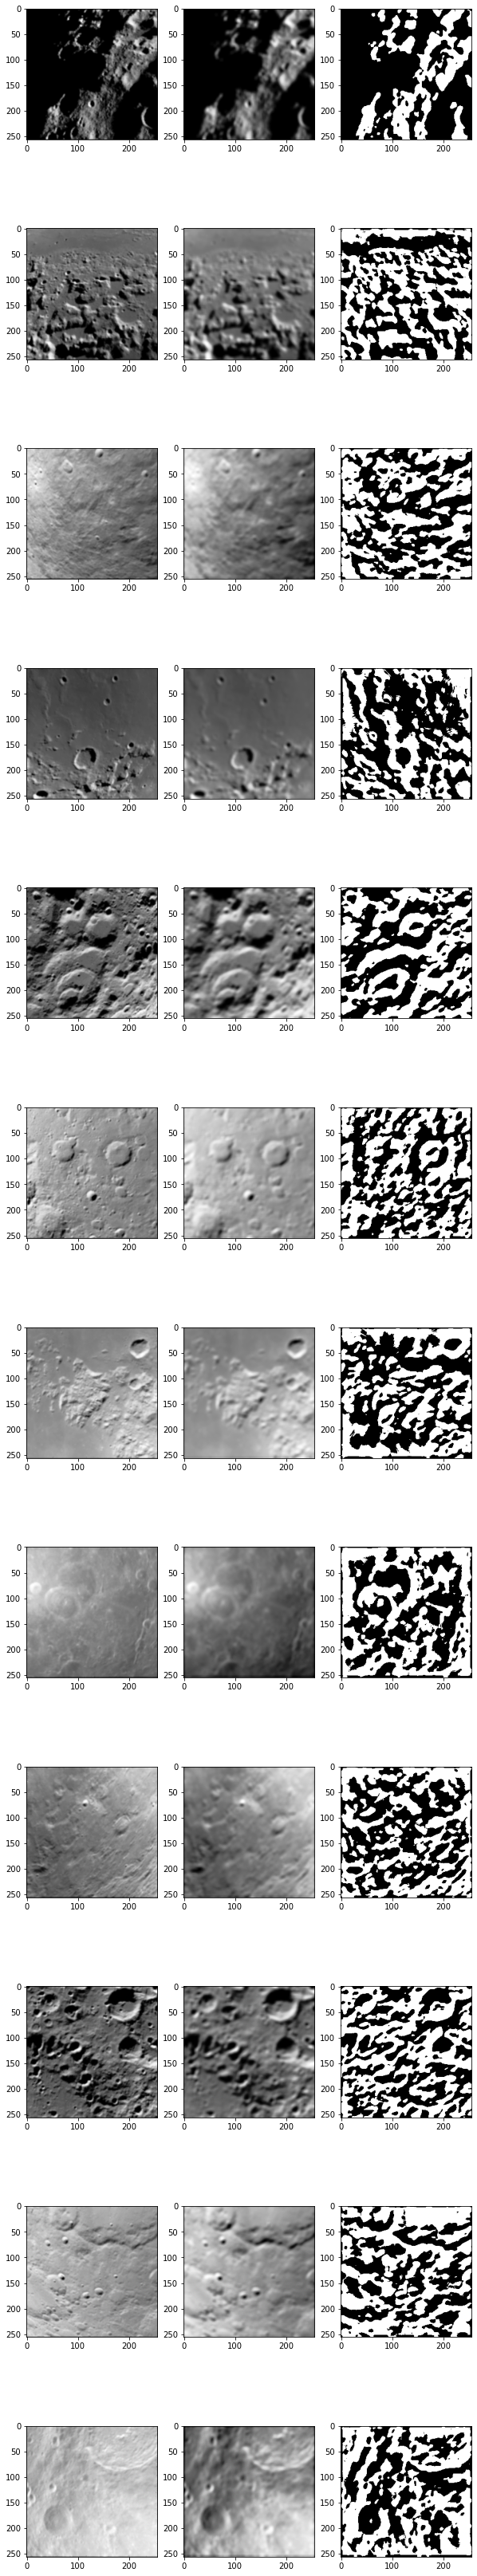

In [75]:
n_images = 12
fig, axes = plt.subplots(n_images, 3, figsize=(10, 60))

for i in range(n_images):
    test_img = images[i].astype(np.uint8).squeeze()
    blurred = cv2.GaussianBlur(test_img, (7, 7), 5)
    out = cv2.adaptiveThreshold(blurred,
                          maxValue=255,
                          adaptiveMethod=cv2.ADAPTIVE_THRESH_MEAN_C,
                          thresholdType=cv2.THRESH_BINARY,
                          blockSize=51,
                          C=0)

    axes[i, 0].imshow(test_img, cmap='Greys_r')
    axes[i, 1].imshow(blurred, cmap='Greys_r')
    axes[i, 2].imshow(out, cmap='Greys_r')